# Objetivo:

    Utilizando os dados tratados anteriormoente, desenvolver um modelo de classificação que seja eficiente para identificar quando o empréstimo for de risco ou não.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url='https://raw.githubusercontent.com/robertferro/analisando_risco_credito/main/1-%20Tratamento%20de%20dados%20(ETL)/dados_analise_risco_de_cresdito.csv'

In [3]:
df = pd.read_csv(url,sep=',')

In [4]:
df.head()

,idade,tempo_de_emprego,tipo_moradia,objetivo_emprestimo,montante_emprestimo,taxa_juros,renda_por_ano,porc_empr_renda_anual,class_risco_historico,inadimplencia_hist,qtd_anos_primeiro_emprestimo,risco_emprestimo,tipo_moradia_id,objetivo_emprestimo_id,class_risco_historico_id
0,21,5.0,propria,educacao,1000,11.14,9600,0.10,B,0,2,0,3,1,1
1,25,1.0,hipoteca,saude,5500,12.87,9600,0.57,C,0,3,1,1,5,2
2,23,4.0,alugada,saude,35000,15.23,65500,0.53,C,0,2,1,0,5,2
3,24,8.0,alugada,saude,35000,14.27,54400,0.55,C,1,4,1,0,5,2
4,21,2.0,propria,risco,2500,7.14,9900,0.25,A,0,2,1,3,4,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31679 entries, 0 to 31678
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   idade                         31679 non-null  int64  
 1   tempo_de_emprego              31679 non-null  float64
 2   tipo_moradia                  31679 non-null  object 
 3   objetivo_emprestimo           31679 non-null  object 
 4   montante_emprestimo           31679 non-null  int64  
 5   taxa_juros                    31679 non-null  float64
 6   renda_por_ano                 31679 non-null  int64  
 7   porc_empr_renda_anual         31679 non-null  float64
 8   class_risco_historico         31679 non-null  object 
 9   inadimplencia_hist            31679 non-null  int64  
 10  qtd_anos_primeiro_emprestimo  31679 non-null  int64  
 11  risco_emprestimo              31679 non-null  int64  
 12  tipo_moradia_id               31679 non-null  int64  
 13  o

# Pré-processamento dos dados

In [6]:
dados=df.copy()
for col in dados.columns:
    if "_id" in col:
        dados.drop(col,axis=1,inplace=True)
dados.head()

,idade,tempo_de_emprego,tipo_moradia,objetivo_emprestimo,montante_emprestimo,taxa_juros,renda_por_ano,porc_empr_renda_anual,class_risco_historico,inadimplencia_hist,qtd_anos_primeiro_emprestimo,risco_emprestimo
0,21,5.0,propria,educacao,1000,11.14,9600,0.10,B,0,2,0
1,25,1.0,hipoteca,saude,5500,12.87,9600,0.57,C,0,3,1
2,23,4.0,alugada,saude,35000,15.23,65500,0.53,C,0,2,1
3,24,8.0,alugada,saude,35000,14.27,54400,0.55,C,1,4,1
4,21,2.0,propria,risco,2500,7.14,9900,0.25,A,0,2,1


In [46]:
df.objetivo_emprestimo.unique()

array(['educacao', 'saude', 'risco', 'pessoal', 'reformar_casa',
       'consolidacao_debito'], dtype=object)

In [7]:
# Criando dicionarios para as variáveis categóricas


dic_tipo_moradia={'propria':0, 'hipoteca':1, 'alugada':2, 'outro':3}
dados['tipo_moradia'] = dados['tipo_moradia'].map(dic_tipo_moradia)

dic_objetivo_emprestimo={'educacao':0, 'saude':1, 'risco':2, 'pessoal':3, 'reformar_casa':4,'consolidacao_debito':5}
dados['objetivo_emprestimo'] = dados['objetivo_emprestimo'].map(dic_objetivo_emprestimo)

dic_class_risco_historico={'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6}
dados['class_risco_historico'] = dados['class_risco_historico'].map(dic_class_risco_historico)



dados.head()

,idade,tempo_de_emprego,tipo_moradia,objetivo_emprestimo,montante_emprestimo,taxa_juros,renda_por_ano,porc_empr_renda_anual,class_risco_historico,inadimplencia_hist,qtd_anos_primeiro_emprestimo,risco_emprestimo
0,21,5.0,0,0,1000,11.14,9600,0.10,1,0,2,0
1,25,1.0,1,1,5500,12.87,9600,0.57,2,0,3,1
2,23,4.0,2,1,35000,15.23,65500,0.53,2,0,2,1
3,24,8.0,2,1,35000,14.27,54400,0.55,2,1,4,1
4,21,2.0,0,2,2500,7.14,9900,0.25,0,0,2,1


In [43]:
dados.describe()

,idade,tempo_de_emprego,tipo_moradia,objetivo_emprestimo,montante_emprestimo,taxa_juros,renda_por_ano,porc_empr_renda_anual,class_risco_historico,inadimplencia_hist,qtd_anos_primeiro_emprestimo,risco_emprestimo
count,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,3.167900e+04,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000
mean,27.730673,4.782064,1.438019,2.287446,9659.962436,11.037008,6.649010e+04,0.169610,1.226617,0.177657,5.809211,0.215442
std,6.213427,4.034948,0.636457,1.717229,6334.360554,3.070182,5.276879e+04,0.106269,1.168138,0.382230,4.059710,0.411135
min,20.000000,0.000000,0.000000,0.000000,500.000000,5.420000,4.000000e+03,0.000000,0.000000,0.000000,2.000000,0.000000
25%,23.000000,2.000000,1.000000,1.000000,5000.000000,8.490000,3.936600e+04,0.090000,0.000000,0.000000,3.000000,0.000000
50%,26.000000,4.000000,2.000000,2.000000,8000.000000,11.011695,5.600000e+04,0.150000,1.000000,0.000000,4.000000,0.000000
75%,30.000000,7.000000,2.000000,4.000000,12500.000000,13.160000,8.000000e+04,0.230000,2.000000,0.000000,8.000000,0.000000
max,94.000000,41.000000,3.000000,5.000000,35000.000000,23.220000,2.039784e+06,0.830000,6.000000,1.000000,30.000000,1.000000


In [42]:
dados.columns

Index(['idade', 'tempo_de_emprego', 'tipo_moradia', 'objetivo_emprestimo',
       'montante_emprestimo', 'taxa_juros', 'renda_por_ano',
       'porc_empr_renda_anual', 'class_risco_historico', 'inadimplencia_hist',
       'qtd_anos_primeiro_emprestimo', 'risco_emprestimo'],
      dtype='object')

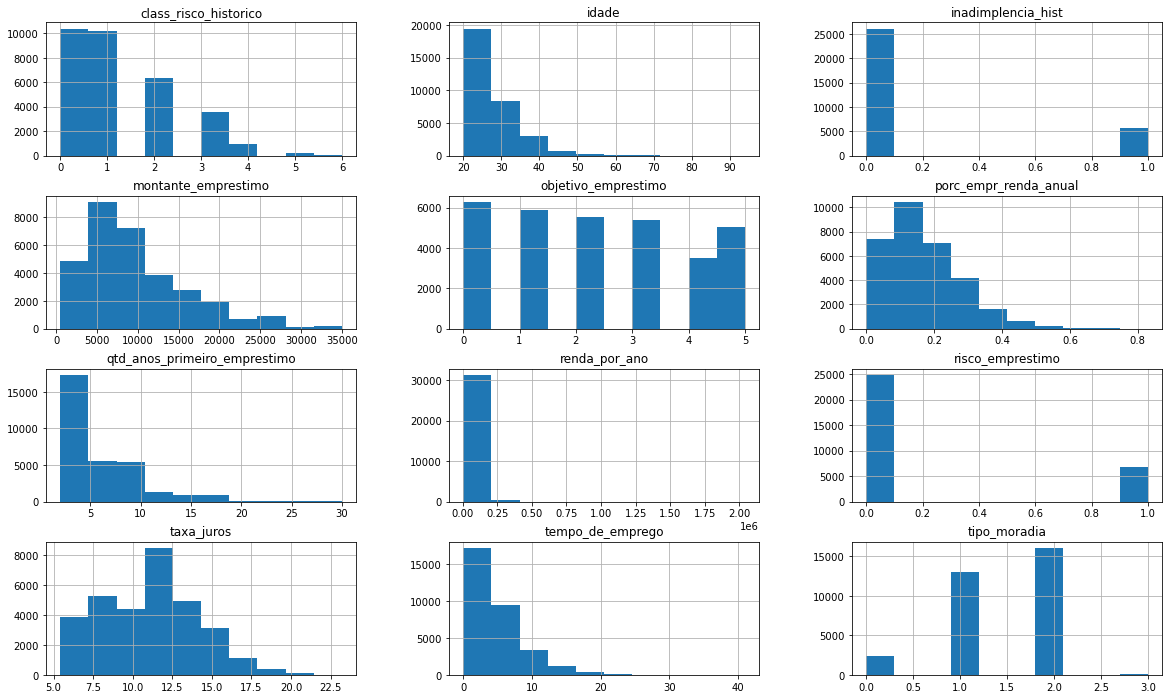

In [10]:
dados.hist(figsize=(20,12));

# Divisão treino e teste e validação

In [22]:
#  criando um dataset apenas com as variáveis numéricas
dados_ml = dados[:26000]
dados_validacao=dados[26000:]


X = dados_ml.drop('risco_emprestimo',axis=1)
y = dados_ml['risco_emprestimo']

# Machine learning

Feature importance 

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

_ = clf.fit(X,y)

features = pd.DataFrame()
features['feature'] = X.columns
features['importancia'] = clf.feature_importances_

# features[ features.importancia > np.mean(features.importancia)].sort_values(by='importancia',ascending=False)
features.sort_values(by='importancia',ascending=False).reset_index(drop=True)

,feature,importancia
0,porc_empr_renda_anual,0.229024
1,renda_por_ano,0.145716
2,taxa_juros,0.114293
3,class_risco_historico,0.111225
4,tipo_moradia,0.107165
5,montante_emprestimo,0.074773
6,objetivo_emprestimo,0.072983
7,tempo_de_emprego,0.063116
8,idade,0.040218
9,qtd_anos_primeiro_emprestimo,0.030424


Dividino as amostras em treino e teste

In [13]:
from sklearn.model_selection import train_test_split

X_treino, X_teste, Y_treino, Y_teste = train_test_split(X,y, test_size=0.2,stratify=y)

- Benchmark

A acurácia do dummy mostfrequent foi 78.08%


Text(33.0, 0.5, 'Real ( 1 ou 0)')

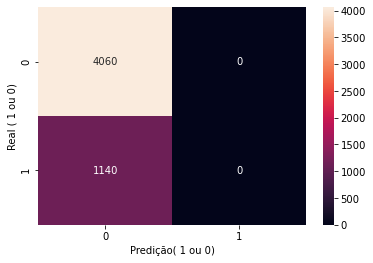

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_treino, Y_treino)
y_pred = dummy_clf.predict(X_teste)
acuracia = dummy_clf.score(X_teste, Y_teste) * 100

print('A acurácia do dummy mostfrequent foi %.2f%%' % acuracia)

from sklearn.metrics import confusion_matrix

cm=confusion_matrix(Y_teste, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

plt.xlabel('Predição( 1 ou 0)')
plt.ylabel('Real ( 1 ou 0)')

In [15]:
from sklearn.metrics import  roc_auc_score,roc_curve, classification_report
from sklearn import metrics

y_proba = dummy_clf.predict_proba(X_teste)

print(roc_auc_score(Y_teste, y_proba[:,1]))
print(classification_report(Y_teste, y_pred))

0.5
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4060
           1       0.00      0.00      0.00      1140

    accuracy                           0.78      5200
   macro avg       0.39      0.50      0.44      5200
weighted avg       0.61      0.78      0.68      5200



C:\Users\Biena\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Testando alguns modelos e fazendo também a validação cruzada.

In [16]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



from sklearn.model_selection import cross_val_score

lista_classificacores = [ LogisticRegression(),
                         GaussianNB(),
                         DecisionTreeClassifier(),
                         RandomForestClassifier(),
                         XGBClassifier()]


for clf in lista_classificacores:
  print(clf.__class__.__name__)
  clf.fit(X_treino, Y_treino)
  train_acc = clf.score(X_treino, Y_treino)
  val_score = cross_val_score(clf, X_treino, Y_treino, cv=5)
  test_acc = clf.score(X_teste, Y_teste)
  print('Treino:', train_acc)
  print('Validation score', val_score.mean())
  print('Teste:', test_acc)

  print('ROC AUC')

  y_proba_treino = clf.predict_proba(X_treino)
  roc_treino = roc_auc_score(Y_treino, y_proba_treino[:, 1])
  print('Treino', roc_treino)

  y_proba_teste = clf.predict_proba(X_teste)
  roc_teste = roc_auc_score(Y_teste, y_proba_teste[:, 1])
  print('Test', roc_teste)
  print('='*80)

LogisticRegression
Treino: 0.8077403846153847
Validation score 0.8071634615384615
Teste: 0.8009615384615385
ROC AUC
Treino 0.7664048435808449
Test 0.7541452769855674
GaussianNB
Treino: 0.823076923076923
Validation score 0.8224038461538461
Teste: 0.8282692307692308
ROC AUC
Treino 0.7944387111294247
Test 0.794607639789128
DecisionTreeClassifier
Treino: 1.0
Validation score 0.8813942307692308
Teste: 0.8851923076923077
ROC AUC
Treino 1.0
Test 0.8403616800622246
RandomForestClassifier
Treino: 1.0
Validation score 0.928846153846154
Teste: 0.9326923076923077
ROC AUC
Treino 1.0
Test 0.9249711563391236
XGBClassifier
Treino: 0.927451923076923
Validation score 0.9248076923076922
Teste: 0.9294230769230769
ROC AUC
Treino 0.9320776738971412
Test 0.9278488246478264


# Ajustando o XGBClassifier

In [17]:
# import xgboost as xgb
# clf=xgb.XGBClassifier()
# _ = clf.fit(X,y)

# # xgb.plot_importance(clf,importance_type='weight')
# feat_imp = clf.get_booster().get_score(importance_type='weight')
# feat_imp_df = pd.DataFrame(feat_imp,index=[0]).T.reset_index()
# feat_imp_df.columns=['Feature','Valor']
# feat_imp_df=feat_imp_df.sort_values('Valor',ascending=False).reset_index(drop=True)
# feat_imp_df

In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

kf = KFold(n_splits=5,random_state=0,shuffle=True)

f1_lista=[]
for i,(tr,ts) in enumerate(kf.split(X)):
    Xtr, ytr = X.iloc[tr], y.iloc[tr]
    Xval, yval = X.iloc[ts], y.iloc[ts]
    
    clf = XGBClassifier(max_depth=15,n_estimators=250,seed=42)
    clf.fit(Xtr,ytr)
    
    y_pred=clf.predict(Xval)

    f1_score_ = f1_score(yval,y_pred)
    f1_lista.append(f1_score_)
    print('Fold: {}'.format(i))
    # print('-'*60)
    print('F1_Score: {:.4f}'.format(f1_score_))
    # print(classification_report(yval, y_pred))
    print('='*40)

f1_medio=np.mean(f1_lista)
print('F1 Score médio: {:.4f}'.format(f1_medio))

Fold: 0
F1_Score: 0.8393
Fold: 1
F1_Score: 0.8226
Fold: 2
F1_Score: 0.8394
Fold: 3
F1_Score: 0.8254
Fold: 4
F1_Score: 0.8286
F1 Score médio: 0.8311


A acurácia do XGBCLassifier foi 93.23%


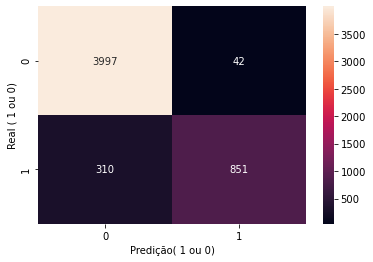

In [41]:
y_pred = clf.predict(Xval)
cm=confusion_matrix(yval, y_proba>0.5)
sns.heatmap(cm, annot=True, fmt='g')
# f1_score_xgb = f1_score(yval,y_pred)
# print('F1 Score do XGBCLassifier foi: {:.4f}'.format(f1_score_xgb))

acuracia = clf.score(Xval, yval) * 100
print('A acurácia do XGBCLassifier foi %.2f%%' % acuracia)


plt.xlabel('Predição( 1 ou 0)')
plt.ylabel('Real ( 1 ou 0)')
plt.show()

In [40]:
y_proba = clf.predict_proba(Xval)[:,1]
roc_auc = roc_auc_score(yval, y_proba)
print('ROC AUC :',roc_auc)

print()

print(classification_report(yval, y_proba>0.5))

ROC AUC : 0.9356824364683782

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4039
           1       0.95      0.73      0.83      1161

    accuracy                           0.93      5200
   macro avg       0.94      0.86      0.89      5200
weighted avg       0.93      0.93      0.93      5200



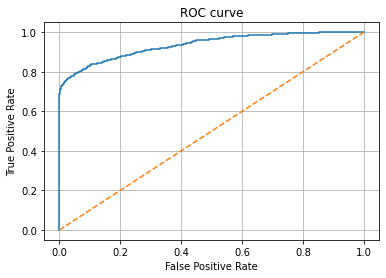

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(yval,y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# Analisando as previsões

In [27]:
#  criando um novo dataset com os valores reais e as probabilidades
analise = Xval.copy()
analise['risco_emprestimo'] = yval
analise['previsao'] = clf.predict(Xval)
analise['pontuacao'] = clf.predict_proba(Xval)[:,1]

analise.head()

,idade,tempo_de_emprego,tipo_moradia,objetivo_emprestimo,montante_emprestimo,taxa_juros,renda_por_ano,porc_empr_renda_anual,class_risco_historico,inadimplencia_hist,qtd_anos_primeiro_emprestimo,risco_emprestimo,previsao,pontuacao
10,21,2.0,0,4,4500,8.63,10000,0.45,0,0,2,1,1,0.999423
13,23,2.0,2,0,35000,7.90,115000,0.30,0,0,4,0,0,0.000494
19,25,2.0,2,2,35000,7.49,162500,0.22,0,0,4,0,0,0.000543
28,21,5.0,3,0,4000,12.84,11389,0.35,2,1,2,1,1,0.999982
40,24,4.0,0,2,2500,12.69,12000,0.21,1,0,3,1,1,0.998116


In [29]:
analise.describe()

,idade,tempo_de_emprego,tipo_moradia,objetivo_emprestimo,montante_emprestimo,taxa_juros,renda_por_ano,porc_empr_renda_anual,class_risco_historico,inadimplencia_hist,qtd_anos_primeiro_emprestimo,risco_emprestimo,previsao,pontuacao
count,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000
mean,25.813077,4.495385,1.444038,2.244615,9327.639423,11.039934,61830.300769,0.171360,1.229038,0.182115,4.552115,0.223269,0.171731,0.193288
std,3.559629,3.565772,0.636112,1.712498,6111.851572,3.057432,39562.112859,0.107663,1.161693,0.385977,2.464594,0.416477,0.377183,0.360844
min,20.000000,0.000000,0.000000,0.000000,500.000000,5.420000,4800.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000006
25%,23.000000,2.000000,1.000000,1.000000,5000.000000,8.490000,38400.000000,0.090000,0.000000,0.000000,3.000000,0.000000,0.000000,0.001665
50%,25.000000,4.000000,2.000000,2.000000,8000.000000,11.011695,54593.000000,0.150000,1.000000,0.000000,4.000000,0.000000,0.000000,0.010703
75%,28.000000,7.000000,2.000000,4.000000,12000.000000,13.160000,75000.000000,0.230000,2.000000,0.000000,6.000000,0.000000,0.000000,0.092251
max,35.000000,19.000000,3.000000,5.000000,35000.000000,22.110000,948000.000000,0.830000,6.000000,1.000000,10.000000,1.000000,1.000000,0.999999


In [ ]:
analise[analise['']]

In [30]:
pd.set_option('max_rows',500)
analise[(analise['previsao']==0) & (analise['risco_emprestimo']==1)].describe()

,idade,tempo_de_emprego,tipo_moradia,objetivo_emprestimo,montante_emprestimo,taxa_juros,renda_por_ano,porc_empr_renda_anual,class_risco_historico,inadimplencia_hist,qtd_anos_primeiro_emprestimo,risco_emprestimo,previsao,pontuacao
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.0,310.0,310.000000
mean,26.235484,4.700000,1.493548,2.383871,8618.467742,11.736067,57662.187097,0.162484,1.445161,0.212903,4.648387,1.0,0.0,0.096315
std,3.879166,3.410957,0.513529,1.763821,6493.874671,2.715511,43854.223437,0.107438,1.077225,0.410022,2.481435,0.0,0.0,0.123425
min,21.000000,0.000000,0.000000,0.000000,900.000000,5.420000,9600.000000,0.020000,0.000000,0.000000,2.000000,1.0,0.0,0.000069
25%,23.000000,2.000000,1.000000,1.000000,4000.000000,10.002500,34971.000000,0.080000,1.000000,0.000000,3.000000,1.0,0.0,0.010474
50%,25.000000,4.500000,1.500000,3.000000,7000.000000,11.490000,51000.000000,0.140000,1.000000,0.000000,4.000000,1.0,0.0,0.037721
75%,28.000000,7.000000,2.000000,4.000000,11175.000000,13.490000,72000.000000,0.220000,2.000000,0.000000,6.750000,1.0,0.0,0.130103
max,35.000000,16.000000,2.000000,5.000000,35000.000000,19.410000,648000.000000,0.650000,5.000000,1.000000,10.000000,1.0,0.0,0.479068


# Fazendo as previsões para os dados de validação

Separando os dados de validação em X e y

In [ ]:
X_val=dados_validacao.drop(columns='risco_emprestimo',axis=1)
y_val=dados_validacao['risco_emprestimo']

In [ ]:
dados_validacao

In [ ]:
# Ajustando o modelo aos dados de treino e teste
clf.fit(X,y)

# Gerando as previsões
y_pred_validacao=clf.predict(X_val)



cm=confusion_matrix(y_val, y_pred_validacao)
sns.heatmap(cm, annot=True, fmt='g')


f1_score_xgb_validacao=f1_score(y_val,y_pred_validacao)
print('F1 Score do XGBCLassifier na validação foi: {:.4f}'.format(f1_score_xgb_validacao))
acuracia = clf.score(X_val, y_val) * 100
print('A acurácia do XGBCLassifier na validação foi %.2f%%' % acuracia)


plt.xlabel('Predição( 1 ou 0)')
plt.ylabel('Real ( 1 ou 0)')
plt.show()

In [ ]:
y_proba_validacao = clf.predict_proba(X_val)[:,1]
roc_auc = roc_auc_score(y_val, y_proba_validacao)
print('ROC AUC :',roc_auc)

print()

print(classification_report(y_val, y_proba_validacao>0.5))

In [ ]:
clf.predict_proba(X_teste[0:5])[:,1]

Salvando o modelo

In [ ]:
import pickle

output = open('modelo_analise_credito', 'wb')
pickle.dump(clf, output)
output.close()


# modelo = open('modelo_analise_credito', 'rb')
# new_model = pickle.load(modelo)
# modelo.close()

In [ ]:

#  abrindo o arquivo salvo
modelo = open('modelo_analise_credito', 'rb')
new_model = pickle.load(modelo)


In [ ]:
new_model.predict_proba(X_teste[0:5])[:,1]